<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/for-ideas/%D0%A1NN_with_color_pic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Часть 2\***
***CNN с цветными изображениями***

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
from google.colab import drive
from sklearn.externals import joblib 
from PIL import Image, ImageDraw

# подключение гугл-диска
drive.mount('/content/drive')

RANDOM_SEED = 42
PATH = '/content/drive/My Drive/Курсач/files/'

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mounted at /content/drive


In [34]:
#Загрузим всё необходимое
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import time

all_features = joblib.load(os.path.join(PATH,'all_features_color.pkl'))
#x_test = joblib.load(os.path.join(PATH,'x_test.pkl'))
#x_train = joblib.load(os.path.join(PATH,'x_train.pkl'))
y_train = joblib.load(os.path.join(PATH,'y_train_color.pkl'))
y_test = joblib.load(os.path.join(PATH,'y_test_color.pkl'))

features_list = ['Haars features', 'Matrix features','Matrix + PCA features']
categories = ['hf_train', 'mf_train','pca_train', 'hf_test', 'mf_test', 'pca_test']
net_cols = ['fully_con_net_cpu', 'fully_con_net_gpu','convol_net_cpu', 'convol_net_gpu']

net_time_df = pd.DataFrame(index = categories, columns = net_cols)
net_accuracy = pd.DataFrame(features_list, index=['1', '2', '3'], columns=['features'])

In [35]:
class ConvNet(nn.Module): 
    def __init__(self): 
         super(ConvNet, self).__init__() 
         self.layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
         self.layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

         self.drop_out = nn.Dropout() 
         self.fc1 = nn.Linear(in_features= 2*2*64, out_features=64)
         self.fc2 = nn.Linear(in_features=64, out_features=32)
         self.fc3 = nn.Linear(in_features=32, out_features=2)
    
    def forward(self, x):
         out = F.relu(F.max_pool2d(self.layer1(x), 3))
         out = F.relu(F.max_pool2d(self.layer2(out), 2))
         out = self.drop_out(out) 
         out = out.view(out.size(0), -1)
         out = F.relu(self.fc1(out))
         out = F.relu(self.fc2(out))
         out = F.sigmoid(self.fc3(out))
         return out

In [36]:
def plot_graphic(y_points, title):
    x_points = lambda x: np.arange(0,len(y_points[x]))

    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=18, fontname='Times New Roman')
    plt.xlabel('Epoch',fontsize=16, fontname='Times New Roman')
    plt.ylabel('Score',fontsize=16, fontname='Times New Roman')
    plt.plot(x_points(0), y_points[0], color='#fb607f', linestyle='-')
    if len(y_points) > 1:
        plt.plot(x_points(1), y_points[1], color='#906bff', linestyle='-')
        plt.plot(x_points(2), y_points[2], color='#c71585', linestyle='-')
        plt.legend(features_list, loc='center', shadow=True,fontsize=18)
    else:  plt.legend(['matrix'], loc='center', shadow=True,fontsize=18)
    plt.show()

In [37]:
def nn_training(x_train, y_train, is_gpu, loop, time_df, feature_type, index,
                y_points_acc, y_points_loss, y_points_val, net_type, learning_rate):
    
    #Зафиксируем всё, что фиксируется, чтобы получать одинаковые результаты между запусками
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    
    if (net_type == 'convolution'):
        net = ConvNet()
        net_index = 1
    else:
        net = Net(len(x_train[0]))
        net_index = 0

    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    #сделаем массивы точек для построения гафиков accuracy при обучении
    y_points_for_one, y_loss_points_for_one, y_val_points_for_one = [], [], []

    t0 = time.time()

    #поделим ещё немного x_train, чтобы сделать  x_validate
    x_train, x_validate  = np.split(x_train, [int(0.75*len(x_train))])
    y_train, y_validate  = np.split(y_train, [int(0.75*len(y_train))])

    x_train_torch, x_validate_torch = torch.from_numpy(x_train).float(), torch.from_numpy(x_validate).float()
    y_train_torch,y_validate_torch = torch.from_numpy(y_train), torch.from_numpy(y_validate)

    if net_type == 'convolution':
        x_train_torch = torch.reshape(x_train_torch, (len(x_train_torch), 3, 25, 25))
        x_validate_torch = torch.reshape(x_validate_torch, (len(x_validate_torch), 3, 25, 25))

    #будем проверять на 2-х процессорах
    if is_gpu == 1:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")
    net.to(device)

    x_train_torch, y_train_torch = x_train_torch.to(device), y_train_torch.to(device)
    x_validate_torch, y_validate_torch = x_validate_torch.to(device), y_validate_torch.to(device)
    print('\n', net_type, ' network')
    print('Feature type: ', feature_type)
    print(device)

    for epoch in range(loop): # loop
        optimizer.zero_grad()
        output = net(x_train_torch)
        loss = criterion(output, y_train_torch)
        loss.backward()
        #clip_grad_norm(net.parameters(), 0.01)
        optimizer.step()

        with torch.no_grad():
             validate_output = net(x_validate_torch)

        y_loss_points_for_one.append(loss.item())
        y_points_for_one.append(accuracy_score(y_train, torch.argmax(output.data, dim = 1 ).cpu()))
        y_val_points_for_one.append(accuracy_score(y_validate, torch.argmax(validate_output.data, dim = 1 ).cpu()))

        if len(y_val_points_for_one) >=100 and np.all(y_val_points_for_one[-100:] == y_val_points_for_one[-1]):
            print('Early stopping! No changes in last 100 epoch for validation samples! Epoch: ', epoch)
            break
    t = time.time()
    print('Last validation accuracy: ', y_val_points_for_one[-1])
    print('Last train accuracy: ', y_points_for_one[-1])
    print('Loss: ', y_loss_points_for_one[-1])

    #сохраним обученную сеть        
    torch.save(net.state_dict(), os.path.join(PATH, 'Networks', feature_type + '_' + net_type + '_neural_net.pth'))
    
    #заполним табличку с временем
    time_df.loc[categories[index]][net_cols[is_gpu + 2 * net_index]] += (t - t0)

    #что-то не чистится:(
    del x_train_torch, y_train_torch, x_validate_torch, y_validate_torch
    torch.cuda.empty_cache()

    #нарисуем график 
    if is_gpu == 1:
        y_points_acc.append(y_points_for_one)
        y_points_loss.append(y_loss_points_for_one)
        y_points_val.append(y_val_points_for_one)
        if len(y_points_acc) == 3 or net_type == 'convolution':
            plot_graphic(y_points_val, 'Accuracy score for validation')
            plot_graphic(y_points_acc, 'Accuracy score for train')
            plot_graphic(y_points_loss, 'Loss')

In [45]:
def nn_test(x_test, is_gpu, feature_type, data_df, time_df, index, net_type):

    x_test_torch = torch.from_numpy(x_test).float()

    if (net_type == 'convolution'):
        net = ConvNet()
        net_index = 1
        x_test_torch = torch.reshape(x_test_torch, (len(x_test_torch),3, 25, 25))
    else:
        net = Net(len(x_test[0]))
        net_index = 0
    net.load_state_dict(torch.load(os.path.join(PATH, 'Networks', feature_type + '_' + net_type + '_neural_net.pth')))

    t0 = time.time()
  
    
    with torch.no_grad():
        output = net(x_test_torch)
        data_df['cnn'] = torch.argmax(output.data, dim = 1)
    t = time.time()  

#Запуск

После инициализации всех необходимых функций, самое время ими воспользоваться:)  
Проводить эксперименты мы будем на 3-х признаках для полносвязной нейронной сети, и на исходной матрицы изображения 25*25 пикселей для свёрточной нейронной сети.  
Также попробуем позапускать весь процесс на двух типах процессора для оценки временных затрат каждого.

**Примечание:** поскольку google colab жадничает ресурсы, обучить сразу две сети не получается. Поэтому будем проводить обучение одной нейронки с сохранением всех данных, потом перезапустим среду и запустим аналогичный алгоритм для второй нейронки.

In [29]:
from pandas import read_csv

def save_df(haars_net_df, matrix_net_df, matrix_net_pca_df, net_time_df):
    haars_net_df.to_csv(os.path.join(PATH, 'Dataframes', 'haars_net_df.csv'))
    matrix_net_df.to_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_df.csv'))
    matrix_net_pca_df.to_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_pca_df.csv'))
    net_time_df.to_csv(os.path.join(PATH, 'Dataframes', 'net_time_df.csv'))

def load_df():
    return (read_csv(os.path.join(PATH, 'Dataframes', 'haars_net_df.csv'), index_col=0, header= 0), 
    read_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_df.csv'), index_col=0, header= 0),
    read_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_pca_df.csv'), index_col=0, header= 0),
    read_csv(os.path.join(PATH, 'Dataframes', 'net_time_df.csv'), index_col=0, header= 0))



 convolution  network
Feature type:  mf
cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Last validation accuracy:  0.841775820099687
Last train accuracy:  0.9322590617512946
Loss:  0.37966224551200867


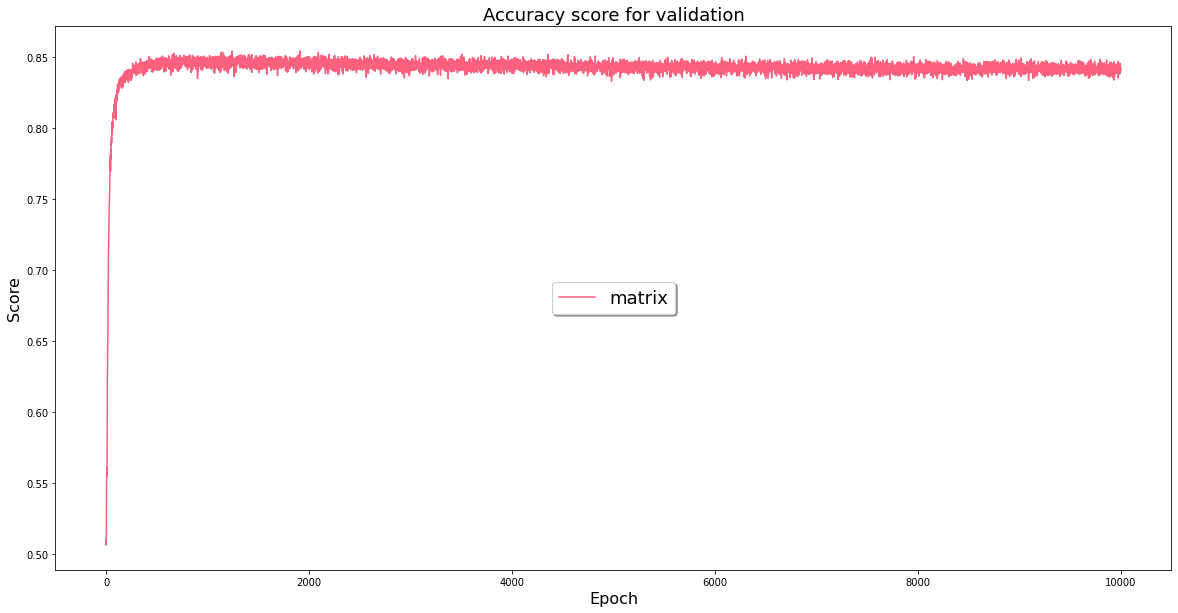

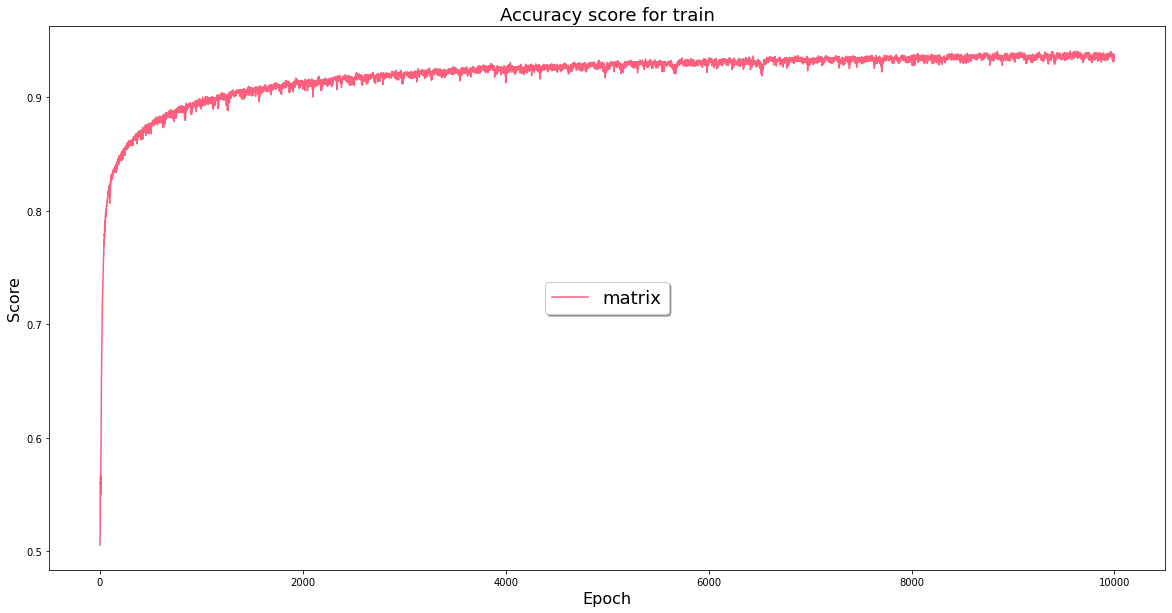

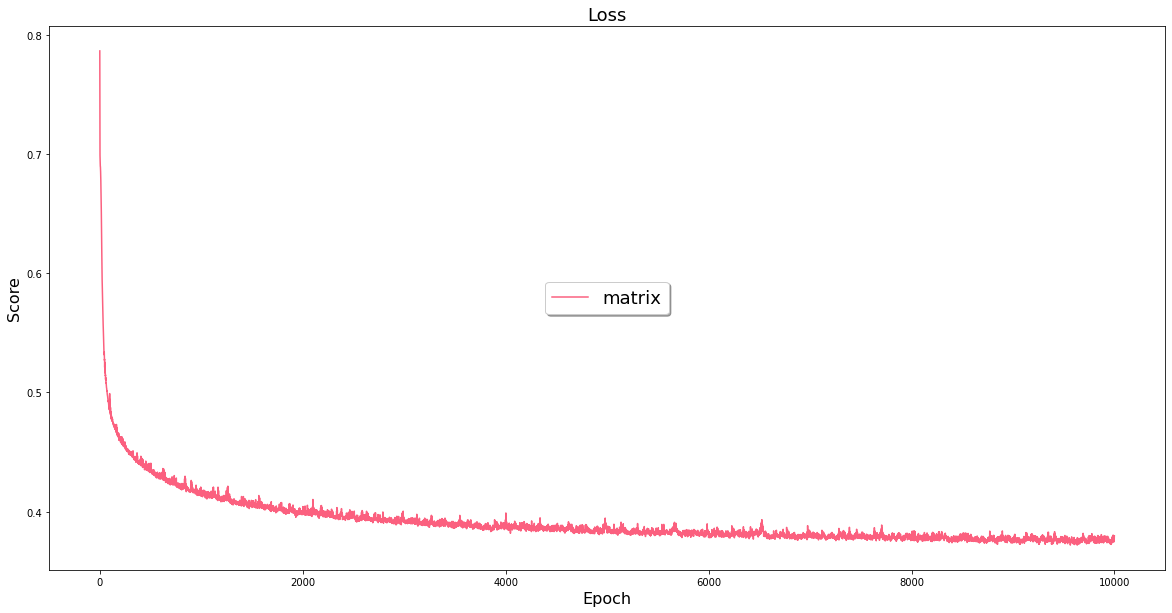

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [56]:
#haars_net_df, matrix_net_df, matrix_net_pca_df, net_time_df = load_df()
cnn_net = pd.DataFrame()
cnn_net['y_test'] = y_test
 
MAX_ITER = 10000
LEARNING_RATE = 0.001
y_points_acc, y_points_loss, y_points_val = [], [], []

nn_training(all_features[1], y_train, 1, MAX_ITER, net_time_df, 'mf', 1, y_points_acc, y_points_loss, y_points_val, 'convolution', LEARNING_RATE)
nn_test(all_features[4], 1, 'mf', cnn_net, net_time_df, 4, 'convolution') 
 
#save_df(haars_net_df, matrix_net_df, matrix_net_pca_df, net_time_df)

In [57]:
cnn_net[:5]

,y_test,cnn
0,0,0
1,1,1
2,1,0
3,1,1
4,1,1


In [58]:
print( accuracy_score(cnn_net['y_test'], cnn_net['cnn']))

0.8428099460963311


#Вывод
1000 итераций - 0.84  
3000 итераций - 0.83  
10000 итераций - 0.84
   
Что ж, ну прикольно. Получается примерно столько же, как и на ч\б с при условии, что картинок стало в два раза меньше(от большего числа цветных картинок колаб вываливается и предлагает поиздеваться над кем-нибудь ещё :( )   
        
Но по идее можно сказать о том, что цветные изображения действительно более информативные, и если бы была возможность грузить исходную выборку в цвете, то можно было бы получить неплохой результат, но во вселенной ограниченных ресурсов добиться чего-то действительно крутого будет куда сложнее, чем казалось..